# Notebook file to calculate the AM of eigenmodes of a sphere

## Import all libs

In [19]:
from src.dispersion import * 
from src.VSH import * 
from src.extra_special import * 

import numpy as np
import scipy.constants as const
import scipy.special as sp
from scipy import integrate
from cxroots import Rectangle, AnnulusSector, Circle
from icecream import ic

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

Z_0 = np.sqrt(const.mu_0 / const.epsilon_0)  # vacuum impedance

## Find eigen frequency

### Particle parameters

If particle dielectric then
$$
\varepsilon_{\text{in}} = \varepsilon_{\text{dielectric}}, \qquad \mu_{\text{in}} = \mu_{\text{dielectric}}
$$
If particle is metallic then
$$
\varepsilon_{\text{in}}(\omega) = \varepsilon_{\infty} - \frac{\omega_p^2}{\omega^2 + i \Gamma \omega}
$$
where parameters are taken for Gold from Novotny book p. 380: 
- $\varepsilon_\infty = 1$
- $\omega_p = 13.8 \cdot 10^{15} \text{ [1/s]}$
- $\Gamma = 1.075 \cdot 10^{14} \text{ [1/s]}$

In [20]:
particle_type = "dielectric"  # "dielectric" or "metallic"
eps_dielectric = 10 + 0.0j
mu_dielectric = 1.0 + 0.0j

n = 1  # m = -n, ..., n

a = 40*const.nano

mode_type = "TE"  # "TE" or "TM"

eps_out = 1
mu_out = 1

### Dispersion equations

In compact form we can write them as
\begin{equation}
	\text{dispersion eq. for TE:} \qquad \frac{\mu_\text{in}}{\mu_\text{out}} \left( 1 + n_{\text{out}} z \frac{h_n^{(1)\prime} (n_{\text{out}} z)}{h_n^{(1)} (n_{\text{out}} z)}  \right) = 1 + n_\text{in} z \frac{j_n^\prime(n_\text{in} z)}{j_n (n_\text{in} z)}
\end{equation}
\begin{equation}
	\text{dispersion eq. for TM:} \qquad \frac{\varepsilon_\text{in}}{\varepsilon_\text{out}} \left( 1 + n_{\text{out}} z \frac{h_n^{(1)\prime} (n_{\text{out}} z)}{h_n^{(1)} (n_{\text{out}} z)}  \right) = 1 + n_\text{in} z \frac{j_n^\prime(n_\text{in} z)}{j_n (n_\text{in} z)}
\end{equation}
Here $z=k_0 a = \frac{\omega}{c} a \in \mathbb{Z}$ is the dimensionless **frequency**, and $n_{\text{in}} = \sqrt{\varepsilon_{\text{in}} \mu_{\text{in}}}$, $n_{\text{out}} = \sqrt{\varepsilon_{\text{out}} \mu_{\text{out}}}$. Prime shows the derivative with respect to the argument.

Which can be rewritten in a more sutable form for the numeric computation for TE modes
\begin{equation}
    f_{\text{TE}}(z) =  z \left( \frac{\mu_{\text{in}} }{\mu_{\text{out}}} n_{\text{out}} j_n h_n^\prime - n_{\text{in}} j_n^\prime h_n  \right)
    + h_n j_n \left( \frac{\mu_{\text{in}} }{\mu_{\text{out}}} - 1\right) = 0
\end{equation}
\begin{equation}
\frac{d}{dz}f_{\text{TE}}(z) = 
j_n h_n^\prime n_{\text{out}} \left( 2 \frac{\mu_{\text{in}} }{\mu_{\text{out}}} - 1\right)
+ j_n^\prime h_n n_{\text{in}} \left( \frac{\mu_{\text{in}} }{\mu_{\text{out}}} - 2\right)
+ z \left\{ j_n^\prime h_n^\prime n_{\text{out}} n_{\text{in}} \left( \frac{\mu_{\text{in}} }{\mu_{\text{out}}} - 1\right) 
+ \frac{\mu_{\text{in}} }{\mu_{\text{out}}} n_{\text{out}}^2 j_n h_n^{\prime \prime} - n_{\text{in}}^2 j_n^{\prime \prime} h_n \right\}
\end{equation}

and for TM
\begin{equation}
    f_{\text{TM}}(z) =  z \left( \frac{\varepsilon_{\text{in}} }{\varepsilon_{\text{out}}} n_{\text{out}} j_n h_n^\prime - n_{\text{in}} j_n^\prime h_n  \right)
    + h_n j_n \left( \frac{\varepsilon_{\text{in}} }{\varepsilon_{\text{out}}} - 1\right) = 0
\end{equation}
\begin{equation}
\frac{d}{dz}f_{\text{TM}}(z) = 
j_n h_n^\prime n_{\text{out}} \left( 2 \frac{\varepsilon_{\text{in}} }{\varepsilon_{\text{out}}} - 1\right)
+ j_n^\prime h_n n_{\text{in}} \left( \frac{\varepsilon_{\text{in}} }{\varepsilon_{\text{out}}} - 2\right)
+ z \left\{ j_n^\prime h_n^\prime n_{\text{out}} n_{\text{in}} \left( \frac{\varepsilon_{\text{in}} }{\varepsilon_{\text{out}}} - 1\right) 
+ \frac{\varepsilon_{\text{in}} }{\varepsilon_{\text{out}}} n_{\text{out}}^2 j_n h_n^{\prime \prime} - n_{\text{in}}^2 j_n^{\prime \prime} h_n \right\}
\end{equation}




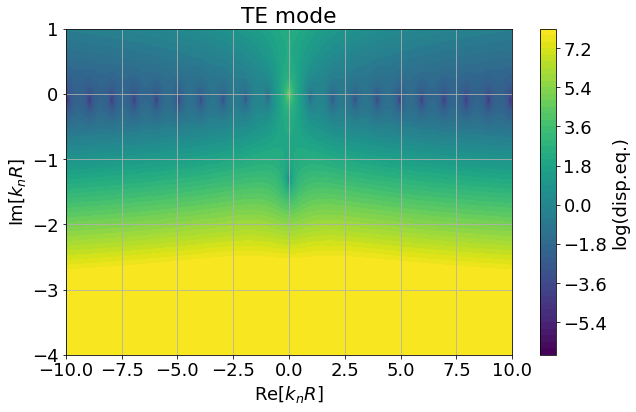

In [21]:
N = 400

z_re = np.linspace(-10, 10, num=N)
z_im = np.linspace(-4, 1, num=N)

X, Y = np.meshgrid(z_re, z_im, sparse=True)

if mode_type == "TE":
    foo_disp_nodiv = fTE
    foo_disp_nodiv_p = fTEp
elif mode_type == "TM":
    foo_disp_nodiv = fTM
    foo_disp_nodiv_p = fTMp

Z = foo_disp_nodiv(n, X + 1j*Y, a, eps_out, mu_out, particle_type, eps_dielectric, mu_dielectric)

Z[np.log(np.abs(Z)) > 8] = np.exp(8)

plt.figure(figsize=(10, 6))
plt.contourf(z_re, z_im, np.log(np.abs(Z)), levels=50)
plt.title(mode_type + " mode")
plt.xlabel("$\operatorname{Re}[k_n R]$")
plt.ylabel("$\operatorname{Im}[k_n R]$")
#plt.yscale("log")
plt.colorbar(label="log(disp.eq.)")
plt.grid()
plt.show()